In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Download Dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [2]:
# Flowers Count
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


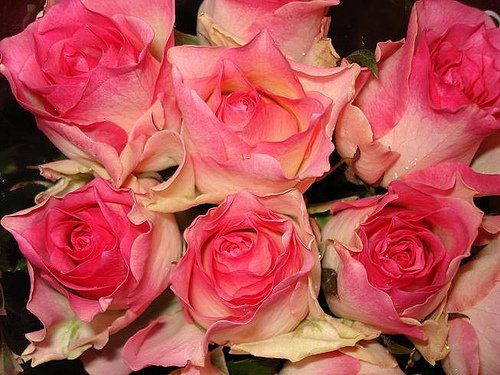

In [3]:
# Some Roses
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[10]))

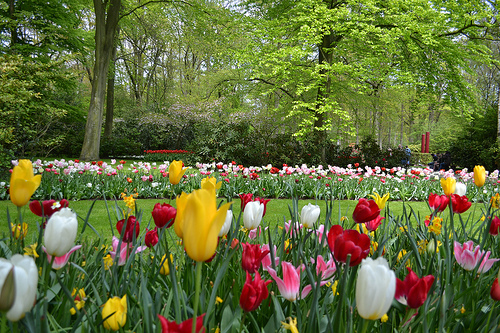

In [4]:
# Some Tulips
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

In [5]:
# Load Train Images
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(180, 180),
  batch_size=32
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [6]:
# Load Validation Images
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(180, 180),
  batch_size=32
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [7]:
# Class
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

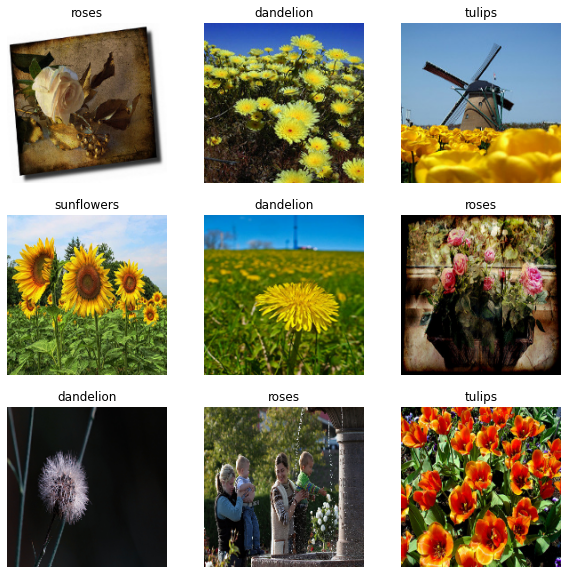

In [8]:
# Data Visualization
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
# Lots
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [10]:
# Create a cache for images
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
# Normalize RGB data, using rescheduling layer - Example
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalization_layer

In [12]:
# Create a model
num_classes = 5

model = Sequential([
  # Normalize RGB data, using rescheduling layer
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
# Compile the Model
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [15]:
# Train the model
epochs=10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 30s 251ms/step - loss: 1.5601 - accuracy: 0.3644 - val_loss: 1.1200 - val_accuracy: 0.5504
Epoch 2/10
92/92 [==============================] - 21s 227ms/step - loss: 1.0348 - accuracy: 0.5959 - val_loss: 0.9857 - val_accuracy: 0.5845
Epoch 3/10
92/92 [==============================] - 22s 235ms/step - loss: 0.8828 - accuracy: 0.6586 - val_loss: 0.9171 - val_accuracy: 0.6294
Epoch 4/10
92/92 [==============================] - 21s 229ms/step - loss: 0.6721 - accuracy: 0.7511 - val_loss: 0.8683 - val_accuracy: 0.6635
Epoch 5/10
92/92 [==============================] - 22s 235ms/step - loss: 0.4487 - accuracy: 0.8467 - val_loss: 0.9300 - val_accuracy: 0.6417
Epoch 6/10
92/92 [==============================] - 21s 228ms/step - loss: 0.2902 - accuracy: 0.9068 - val_loss: 1.1255 - val_accuracy: 0.6213
Epoch 7/10
92/92 [==============================] - 21s 227ms/step - loss: 0.2025 - accuracy: 0.9375 - val_loss: 1.2466 - val_accuracy: 0.6376

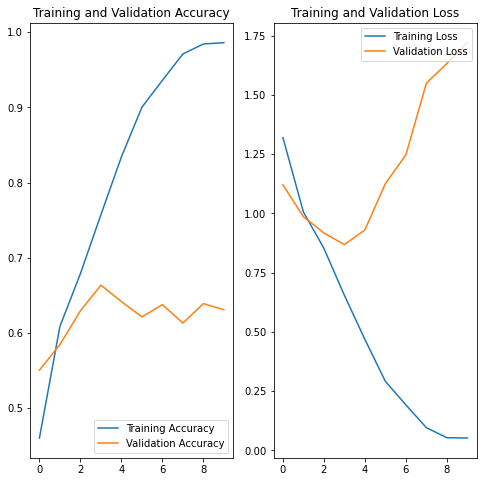

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
# Data Augmentation
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(180, 180, 3)),
    layers.experimental.preprocessing.RandomFlip("vertical", input_shape=(180, 180, 3)),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(180, 180, 3)),
    # Error on this version
    # layers.experimental.preprocessing.RandomRotation(0.1, input_shape=(180, 180, 3)),
    # layers.experimental.preprocessing.RandomZoom(0.1, input_shape=(180, 180, 3)),
  ]
)

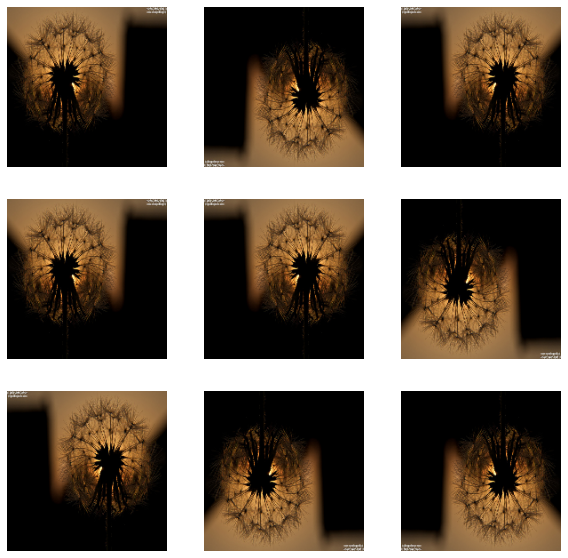

In [18]:
# Show new images
plt.figure(figsize=(10, 10))

for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [19]:
# Create a new model with a new data augmentation and dropout
num_classes = 5

model_augmented = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
# Compile the model
model_augmented.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

In [21]:
model_augmented.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [22]:
epochs_augmented = 15

history_augmented = model_augmented.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs_augmented
)

Epoch 1/15
92/92 [==============================] - 25s 267ms/step - loss: 1.4613 - accuracy: 0.3575 - val_loss: 1.0603 - val_accuracy: 0.5572
Epoch 2/15
92/92 [==============================] - 25s 268ms/step - loss: 1.0472 - accuracy: 0.5998 - val_loss: 0.9899 - val_accuracy: 0.6213
Epoch 3/15
92/92 [==============================] - 24s 260ms/step - loss: 0.9589 - accuracy: 0.6310 - val_loss: 0.9161 - val_accuracy: 0.6267
Epoch 4/15
92/92 [==============================] - 24s 262ms/step - loss: 0.8711 - accuracy: 0.6536 - val_loss: 0.9534 - val_accuracy: 0.6144
Epoch 5/15
92/92 [==============================] - 24s 266ms/step - loss: 0.7596 - accuracy: 0.7115 - val_loss: 0.8089 - val_accuracy: 0.6798
Epoch 6/15
92/92 [==============================] - 28s 303ms/step - loss: 0.7045 - accuracy: 0.7323 - val_loss: 0.7911 - val_accuracy: 0.6798
Epoch 7/15
92/92 [==============================] - 28s 303ms/step - loss: 0.6430 - accuracy: 0.7709 - val_loss: 0.8038 - val_accuracy: 0.6907

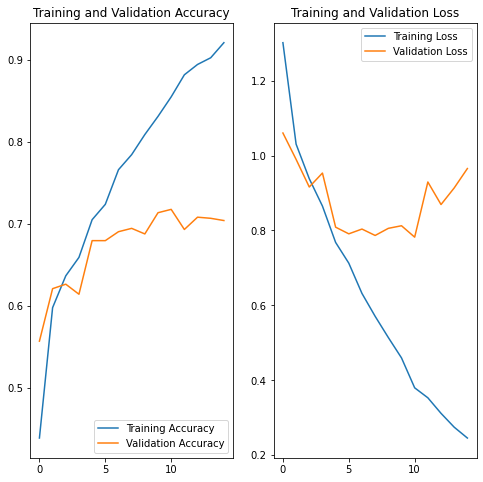

In [23]:
acc = history_augmented.history['accuracy']
val_acc = history_augmented.history['val_accuracy']

loss = history_augmented.history['loss']
val_loss = history_augmented.history['val_loss']

epochs_range = range(epochs_augmented)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

81920/77221 [===============================] - 0s 4us/step


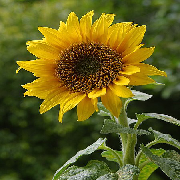

This image most likely belongs to sunflowers with a 96.31 percent confidence.
65536/61536 [===============================] - 0s 3us/step


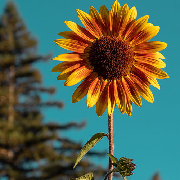

This image most likely belongs to sunflowers with a 93.82 percent confidence.
114688/107159 [================================] - 0s 1us/step


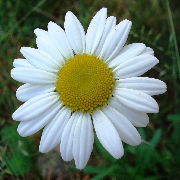

This image most likely belongs to daisy with a 100.00 percent confidence.
1261568/1256730 [==============================] - 2s 1us/step


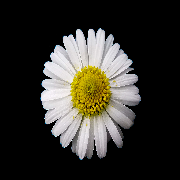

This image most likely belongs to tulips with a 41.63 percent confidence.
 212992/Unknown - 0s 1us/step

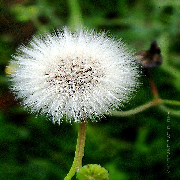

This image most likely belongs to dandelion with a 99.97 percent confidence.
1196032/1193984 [==============================] - 1s 1us/step


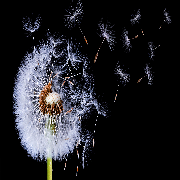

This image most likely belongs to roses with a 62.94 percent confidence.
49152/41033 [===================================] - 0s 1us/step


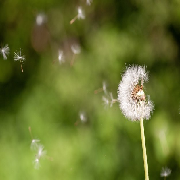

This image most likely belongs to dandelion with a 98.38 percent confidence.


In [42]:
import time
from IPython.display import display

def identify_flower(image_url):
  image_name = 'flower{}'.format(round(time.time() * 1000))

  sunflower_path = tf.keras.utils.get_file(image_name, origin=image_url)

  img = keras.preprocessing.image.load_img(sunflower_path, target_size=(180, 180))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  display(img)

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )
# ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

identify_flower('https://upload.wikimedia.org/wikipedia/commons/thumb/a/a9/A_sunflower.jpg/450px-A_sunflower.jpg') #Sunflower
identify_flower('https://direct.rhapsody.com/imageserver/images/alb.472823045/500x500.jpg') #Sunflower
identify_flower('https://mk0cabiorg09m8anlv96.kinstacdn.com/wp-content/uploads/project-images/Oxeye-daisy-flower_3859338724_o.jpg') #Daisy
identify_flower('https://upload.wikimedia.org/wikipedia/commons/c/ce/Daisy_G%C3%A4nsebl%C3%BCmchen_Bellis_perennis_01.jpg') #Daisy
identify_flower('https://live.staticflickr.com/3490/3898571244_e7e6dd98ef_b.jpg') #Dandelion
identify_flower('https://www.pbs.org/wgbh/nova/media/original_images/shutterstock_617488823.jpg') #Dandelion
identify_flower('https://img.freepik.com/fotos-gratis/closeup-foto-de-foco-seletivo-de-uma-linda-planta-com-flor-dente-de-leao_181624-11960.jpg?size=626&ext=jpg') #Dandelion